# Visualization of 24h FAV signature boat detection over the original spectrograms

### Author: Clausius Duque Gonçalves Reis (clausius@ufv.br)

---
### Load the libraries

In [100]:
import numpy as np
import matplotlib.pyplot as plt

import os
from datetime import datetime
from datetime import timedelta
import pandas as pd
import soundfile as sf

import librosa
import skimage.io
from skimage.transform import resize

---
### Set the variables

In [76]:
currentPath = "/home/clausius/Documents/CODE/Github/FAV-Signature/Code/samples"

dateTimeFormat = "%Y.%m.%d_%H.%M.%S"

spec_width = 1200
spec_height = 600

topDB = 50
audioChannel = 0
timeSample = 60 # Seconds
windowFFT = 2048*2
maximumFrequency = 1000

sampleWindow24h = timeSample

---
### Functions

In [77]:
###########################################################################################################
### Smooth function to allow simple detection within spectrogram
###########################################################################################################
def smooth(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
    return y[window_len:-window_len+1]  

---
### 24H Spectrogram pre-processing

In [78]:


# numCurrentFile24h
numCurrentSpectrogram24h = 0
# numFiles24h
# numFilesSpec24hmaximumFrequency
# numCurrentFiles24h
# numCurrentFilesSpec24h
dateFormat24h = dateTimeFormat

###########################################################################################################
### Create the necessary directories
###########################################################################################################
outputPath = "/".join([currentPath, "24hSpectrogram"])
if (os.path.isdir(outputPath) == False):
    os.system("mkdir %s" % (outputPath))

###########################################################################################################
### Reset the extraction error report
###########################################################################################################
with open("/".join([currentPath, "24hSpectrogram/PROCESSING_ERROR_24hSpectrogram.log"]), "w") as myfile:
    myfile.write("####################################################\n")
    myfile.write("### ERROR REPORT - Seecology                     ###\n")
    myfile.write("####################################################\n")    

###########################################################################################################
### List all the allowed files on the directory
###########################################################################################################
wdir = os.listdir("%s" % (currentPath))
wdir.sort()
currentFiles = [arq for arq in wdir if (arq.lower().endswith(".wav") | 
                                        arq.lower().endswith(".raw") | 
                                        arq.lower().endswith(".flac"))]
currentFiles.sort()

###########################################################################################################
### Get the first and last dates and the number of files to process
###########################################################################################################
#Get first and last dates
if currentFiles[0][-4:] == 'flac':
    day1 = currentFiles[0][:-5]
    day2 = currentFiles[len(currentFiles)-1][:-5]
else:
    day1 = currentFiles[0][:-4]
    day2 = currentFiles[len(currentFiles)-1][:-4]

fromTime = "%s_00.00.00" % ((datetime.strptime(day1, dateFormat24h)).strftime("%Y.%m.%d"))
toTime =   "%s_23.59.59" % ((datetime.strptime(day2, dateFormat24h)).strftime("%Y.%m.%d"))

fromTimeObj = datetime.strptime(fromTime, dateTimeFormat)
toTimeObj = datetime.strptime(toTime, dateTimeFormat)
delta = toTimeObj - fromTimeObj
numFiles24h = delta.days + 1

datelist = pd.date_range(fromTimeObj, toTimeObj).tolist()

numFilesSpec24h = 0    
    
for d in datelist:
    for f in currentFiles:
        if f[0] != ".": # Ignore hidden files
            if f[-4:] == 'flac':
                fileIdent = f[:-5]
            else:
                fileIdent = f[:-4]
            
            if (d.strftime("%Y.%m.%d") == (datetime.strptime(fileIdent, dateFormat24h)).strftime("%Y.%m.%d") ):
                numFilesSpec24h = numFilesSpec24h + 1    

---
### 24H Spectrogram generation

In [112]:
##############################################################################################################################
### EXTRACT 24H SPECTROGRAM ##################################################################################################
##############################################################################################################################    
# Append the spectrogram generation errors
with open("/".join([currentPath, "24hSpectrogram/PROCESSING_ERROR_24hSpectrogram.log"]), "a") as myfile:
    myfile.write("\n")    
    myfile.write("### ERROR ON THE 24H SPECTROGRAM GENERATION ################\n")

numCurrentFiles24h = 0
numCurrentFilesSpec24h = 0

for d in datelist:        
    print("### Day %s " % d.strftime("%Y.%m.%d"))

    firstOk = False
    firstFile = ""
    lastFile = ""

    specMatrixMean = []    
    
    for f in currentFiles:
        try:
            if f[0] != ".": # Ignore hidden files
                if f[-4:] == 'flac':
                    fileIdent = f[:-5]
                else:
                    fileIdent = f[:-4]
                
                if (d.strftime("%Y.%m.%d") == (datetime.strptime(fileIdent, dateFormat24h)).strftime("%Y.%m.%d") ):
                    print("   Processing file %s of %s (%s)" % (numCurrentFilesSpec24h+1, numFilesSpec24h, f))            

                    # Save the first and last file names to extract date/time
                    if firstOk == False:
                        firstFile = fileIdent
                        firstOk = True
                    lastFile = fileIdent
                    
                    frames, rate = sf.read("/".join([currentPath,f]))
                    
                    if (len(np.shape(frames)) == 1):    #Test if audio is mono
                        selChannel = frames                            
                    else:
                        if (audioChannel == 0):         #Select channel if stereo
                            selChannel = frames[:,0]
                        else:
                            selChannel = frames[:,1]

                    # Extract the spectrogram matrix (STFT)
                    specRate = windowFFT
                    sampleWindows = int(len(selChannel)/specRate)
                    specMatrix = np.zeros([int(specRate/2), sampleWindows])
                    
                    for i in range(sampleWindows):
                        t1 = i*specRate
                        t2 = (i+1)*specRate
                        fft = np.fft.fft(selChannel[t1:t2], norm=None)    
                        specMatrix[:,i] = abs(fft[:int(specRate/2)])
                    
                    sampleWindowsOnFile = int(np.floor(int(int(len(frames)/rate))/sampleWindow24h))
                    samplesPerWindow = int(np.shape(specMatrix)[1]/sampleWindowsOnFile)

                    for i in range(sampleWindowsOnFile):
                        t1 = i*samplesPerWindow
                        t2 = (i+1)*samplesPerWindow
                        specMatrixMean.append(np.mean(specMatrix[:,t1:t2], axis=1))

                    numCurrentFilesSpec24h = numCurrentFilesSpec24h + 1
        except:
            print("      --> Error on file: %s" % f)
            numCurrentFiles24h = numCurrentFiles24h + 1
            with open("/".join([currentPath, "24hSpectrogram/PROCESSING_ERROR_24hSpectrogram.log"]), "a") as myfile:
                myfile.write("   %s\n" % f)

    numCurrentFiles24h = numCurrentFiles24h + 1
    
    # Get the maximum frequency from the frequency windows
    freqs = librosa.core.fft_frequencies(sr=rate, n_fft=(specRate)+1)
    if maximumFrequency != 0:            
        maxFreq=1
        while (freqs[maxFreq] < maximumFrequency):
            maxFreq += 1
    else: 
        maxFreq = len(freqs)
    maxFreq = maxFreq - 1

    resImage = np.zeros(shape=(maxFreq, np.shape(specMatrixMean)[0]))
    for i in range(np.shape(specMatrixMean)[0]):
        resImage[0:maxFreq,i] = specMatrixMean[i][0:maxFreq]

    #Cores: Accent, gist_earth, gist_ncar (Perfeito), terrain (Ótimo), nipy_spectral, viridis    
    #speccmap = plt.cm.terrain
    #speccmap = plt.cm.gist_ncar
    #speccmap = plt.cm.nipy_spectral
    specMatrixDB = librosa.amplitude_to_db(resImage, ref=1.0, top_db=topDB)
    specMatrixDB1 = np.flipud(specMatrixDB)
    #specMatrixPWR = librosa.db_to_power(resImage, ref=1.0)
    #specMatrixDB1 = np.flipud(specMatrixPWR)
    
    # Normalization
    normalizationMin = 1000;
    normalizationMax = -1000;
    if np.min(specMatrixDB) < normalizationMin:
        normalizationMin = np.min(specMatrixDB)
    if np.max(specMatrixDB) > normalizationMax:
        normalizationMax = np.max(specMatrixDB)
    norm = plt.Normalize(vmin=normalizationMin, vmax=normalizationMax)

    #DB Mean of the file (VIS)
    specMatrixDBMean = np.mean(specMatrixDB, axis=0)
    #specMatrixDBMeanSmooth = smooth(specMatrixDBMean, window_len=128)
    #np.savetxt("%s/Extraction/24hSpectrogram/SpecPeriod_%s_DBMean.csv" % (currentPath, d.strftime("%Y.%m.%d")), specMatrixDBMeanSmooth)

    #image = speccmap(norm(specMatrixDB1))        
    #image = speccmap(specMatrixDB1)
    #image = norm(specMatrixDB1)
    image = specMatrixDB1 #(VIS)

    newImage = resize(image, (spec_height, spec_width), anti_aliasing=True)
    plt.imsave("%s/24hSpectrogram/SpecPeriod_%s.png" % (currentPath, d.strftime("%Y.%m.%d")), newImage) #(VIS)

    # Save file information for the visualization
    #print("Saving spectrogram info")
    #with open("%s/24hSpectrogram/SpecPeriod_%s.csv" % (currentPath, d.strftime("%Y.%m.%d")), 'wb') as csvfile:
    #    fieldnames = ['from', 'to', 'maxFreq']
    #    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')            
    #    writer.writeheader()

    #    auxFrom = datetime.strptime(firstFile, dateFormat24h) #(VIS)
    #    auxTo   = datetime.strptime(lastFile, dateFormat24h) #(VIS)

        #TODO: Confirmar se a data final foi acrescida do tamanho do último arquivo e se não deu erro...
    #    writer.writerow({'from': "{:%Y-%m-%d %H:%M:%S}".format(auxFrom),
    #                     'to': "{:%Y-%m-%d %H:%M:%S}".format(auxTo + timedelta(seconds=int(len(frames)/rate))), 
    #                     'maxFreq': np.ceil(freqs[maxFreq])})

    numCurrentSpectrogram24h = numCurrentSpectrogram24h + 1

### Day 2015.02.04 
   Processing file 1 of 7 (2015.02.04_05.39.52.wav)
   Processing file 2 of 7 (2015.02.04_10.10.42.wav)
   Processing file 3 of 7 (2015.02.04_10.40.46.wav)
   Processing file 4 of 7 (2015.02.04_21.12.44.wav)
### Day 2015.02.05 


ValueError: zero-size array to reduction operation maximum which has no identity

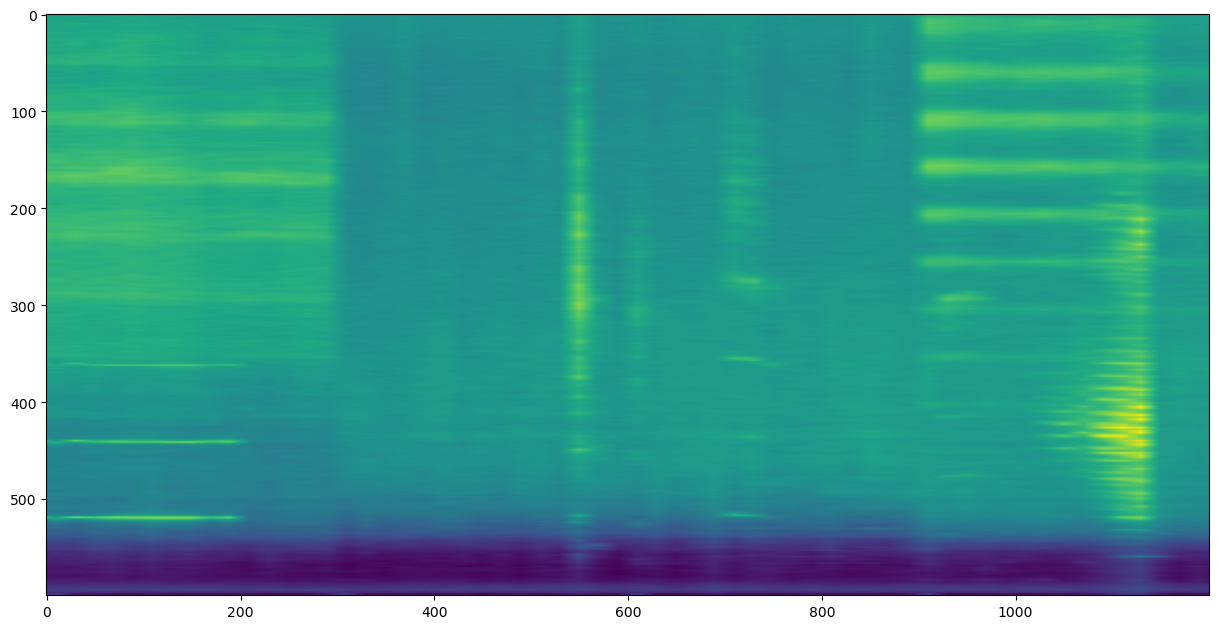

In [113]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax.imshow(newImage)